In [1]:
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
import os
import dask
from ndcctools.taskvine import DaskVine
import hist
import json
import pickle
from cycler import cycler

In [2]:
scale_path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{scale_path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open(f'{scale_path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2
xsecs['diboson_ww'] = xsecs['ww']
xsecs['diboson_wz'] = xsecs['wz']
xsecs['diboson_zz'] = xsecs['zz']

In [3]:
with open('skims/skimmer/triggers.json', 'r') as f:
    triggers = json.load(f)
triggers = triggers['2017']

In [4]:
totals = totals['2017']

In [5]:
cms10 = [
    "#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6",
    "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd",
]
hep.style.use(["CMS", {"axes.prop_cycle": cycler("color", cms10)}])

In [6]:
m = DaskVine(
        [9101,9200],
        name=f"{os.environ['USER']}-hgg",
        run_info_path=f"./",
        run_info_template=f'plotter',
    )

m.tune("temp-replica-count", 3)
m.tune("worker-source-max-transfers", 1000)
m.tune("immediate-recovery", 0)
m.tune("max-retrievals", 1)
m.tune("transient-error-interval", 1)
m.tune("prefer-dispatch", 1)

0

In [7]:
import warnings
warnings.filterwarnings('ignore','Missing cross')
warnings.filterwarnings('ignore','Found duplicate')

In [8]:
samples = {}
path = '/cms/cephfs/data/store/user/cmoore24/samples/2017'
for name in os.listdir(path):
    if ('Jet' not in name) and ('Single' not in name) and ('gg' not in name) and ('flat' not in name) and ('wlnu' not in name) and ('hadronic' not in name) and ('singletop' not in name):
        print(name)
        try:
            samples[name] = NanoEventsFactory.from_root(
                [{f"{path}/{name}/{file}:/Events"} for file in os.listdir(f'{path}/{name}')],
                mode='dask',
                schemaclass=PFNanoAODSchema,
                metadata={'dataset':name}
            ).events()
        except:
            for subset in os.listdir(f'{path}/{name}'):
                if ('qcd' in name) and ('ht' not in name):
                    continue
                else:
                    samples[f'{name}_{subset}'] = NanoEventsFactory.from_root(
                        [{f"{path}/{name}/{subset}/{file}:/Events"} for file in os.listdir(f'{path}/{name}/{subset}')],
                        mode='dask',
                        schemaclass=PFNanoAODSchema,
                        metadata={'dataset':name}
                    ).events()

diboson
zqq
ht_qcd
qcd
wqq
hbb
ttboosted
hww


In [9]:
try:
    del(samples['diboson_ww4q'])
except:
    pass
samples

{'diboson_zz': dask.awkward<from-uproot, npartitions=10>,
 'diboson_ww': dask.awkward<from-uproot, npartitions=38>,
 'diboson_wz': dask.awkward<from-uproot, npartitions=30>,
 'zqq_400to600': dask.awkward<from-uproot, npartitions=200>,
 'zqq_200to400': dask.awkward<from-uproot, npartitions=74>,
 'zqq_600to800': dask.awkward<from-uproot, npartitions=233>,
 'zqq_800toInf': dask.awkward<from-uproot, npartitions=165>,
 'ht_qcd_1000to1500': dask.awkward<from-uproot, npartitions=205>,
 'ht_qcd_500to700': dask.awkward<from-uproot, npartitions=371>,
 'ht_qcd_700to1000': dask.awkward<from-uproot, npartitions=601>,
 'ht_qcd_2000toInf': dask.awkward<from-uproot, npartitions=103>,
 'ht_qcd_100to200': dask.awkward<from-uproot, npartitions=311>,
 'ht_qcd_50to100': dask.awkward<from-uproot, npartitions=106>,
 'ht_qcd_300to500': dask.awkward<from-uproot, npartitions=589>,
 'ht_qcd_200to300': dask.awkward<from-uproot, npartitions=222>,
 'ht_qcd_1500to2000': dask.awkward<from-uproot, npartitions=189>,
 '

In [10]:
def regions(events):
    goodmuon = (
        (events.Muon.pt > 10)
        & (abs(events.Muon.eta) < 2.4)
        & (events.Muon.pfRelIso04_all < 0.25) # invert the isolation cut; > 0.25, check for QCD (maybe try > 1.0)
        & events.Muon.looseId
    )
    
    nmuons = ak.sum(goodmuon, axis=1)
    leadingmuon = ak.firsts(events.Muon[goodmuon])
    
    goodelectron = (
        (events.Electron.pt > 10)
        & (abs(events.Electron.eta) < 2.5)
        & (events.Electron.cutBased >= 2) #events.Electron.LOOSE
    )
    nelectrons = ak.sum(goodelectron, axis=1)
    
    ntaus = ak.sum(
        (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.rawIso < 5)
            & (events.Tau.idDeepTau2017v2p1VSjet)
            & ak.all(events.Tau.metric_table(events.Muon[goodmuon]) > 0.4, axis=2)
            & ak.all(events.Tau.metric_table(events.Electron[goodelectron]) > 0.4, axis=2)
        ),
        axis=1,
    )
    
    # Create masks for the 0-lepton region and the single muon region
    nolepton = ((nmuons == 0) & (nelectrons == 0) & (ntaus == 0))
    singlemuon = ((nmuons == 1) & (nelectrons == 0) & (ntaus == 0))
    return nolepton

In [11]:
def apply_selections(events, pdgid=None, is_wz=False):  

    trigger = ak.zeros_like(ak.firsts(events.FatJet.pt), dtype='bool')
    for t in triggers:
        if t in events.HLT.fields:
            trigger = trigger | events.HLT[t]
    trigger = ak.fill_none(trigger, False)
    events['FatJet', 'trigger_mask'] = trigger
    
    fatjetSelect = (
        (events.FatJet.pt >= 450) &
        (events.FatJet.pt <= 1200)
        & (abs(events.FatJet.eta) <= 2.4)
        & (events.FatJet.msoftdrop >= 40)
        & (events.FatJet.msoftdrop <= 200)
        & (regions(events))
        & (trigger)
        & (events.FatJet.btag_count == 0)
    )


    if ((pdgid != None) or (is_wz)):
        if is_wz:
            genparts = events.GenPart[
                ((abs(events.GenPart.pdgId) == 24)|(events.GenPart.pdgId == 23))
                & events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
            ]
        else:
            genparts = events.GenPart[
                (abs(events.GenPart.pdgId) == pdgid)
                & events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy'])
            ]
        parents = events.FatJet.nearest(genparts, threshold=0.2)
        matched_jets = ~ak.is_none(parents, axis=1)
        fatjetSelect = (fatjetSelect) & (matched_jets)
        return fatjetSelect
    return fatjetSelect

In [12]:
for i in samples:
    samples[i]['FatJet', 'btag_count'] = ak.sum(samples[i].Jet[(samples[i].Jet.pt > 30) 
        & (abs(samples[i].Jet.eta) < 2.5)].btagDeepFlavB > 0.3040, axis=1)

In [13]:
for dataset in samples:
    if ('hgg' in dataset) or ('hbb' in dataset) or ('flat' in dataset) or ('hw' in dataset) or ('vbf' in dataset) or ('hz' in dataset):
        print(f'Higgs {dataset}')
        pdgId = 25
        fatjetSelect = apply_selections(samples[dataset], pdgid=pdgId)
        samples[dataset]["goodjets"] = samples[dataset].FatJet[fatjetSelect]
        do_li = True
    elif ('wqq' in dataset) or ('ww' in dataset) or ('wlnu' in dataset) and ('hww' not in dataset):
        print(dataset)
        pdgId = 24
        fatjetSelect = apply_selections(samples[dataset], pdgid=pdgId)
        samples[dataset]["goodjets"] = samples[dataset].FatJet[fatjetSelect]
        do_li = True
    elif ('zqq' in dataset) or ('zz' in dataset):
        print(dataset)
        pdgId = 23
        fatjetSelect = apply_selections(samples[dataset], pdgid=pdgId)
        samples[dataset]["goodjets"] = samples[dataset].FatJet[fatjetSelect]
        do_li = True
    elif ('wz' in dataset):
        print(dataset)
        pdgId = 'wz'
        fatjetSelect = apply_selections(samples[dataset], pdgid=pdgId, is_wz=True)
        samples[dataset]["goodjets"] = samples[dataset].FatJet[fatjetSelect]
        do_li = True
    else:
        print(dataset)
        pdgId = None
        fatjetSelect = apply_selections(samples[dataset], pdgid=pdgId)
        samples[dataset]["goodjets"] = samples[dataset].FatJet[fatjetSelect]
        do_li = True

diboson_zz
diboson_ww
diboson_wz
zqq_400to600
zqq_200to400
zqq_600to800
zqq_800toInf
ht_qcd_1000to1500
ht_qcd_500to700
ht_qcd_700to1000
ht_qcd_2000toInf
ht_qcd_100to200
ht_qcd_50to100
ht_qcd_300to500
ht_qcd_200to300
ht_qcd_1500to2000
wqq_400to600
wqq_200to400
wqq_600to800
wqq_800toInf
Higgs hbb
ttboosted_1000toInf
ttboosted_700to1000
Higgs hww


In [15]:
trait = {}
for i in samples:
    trait[i] = samples[i].goodjets.msoftdrop

In [16]:
computed = dask.compute(
           trait,
           scheduler=m.get,
           resources={"cores": 2},
           prune_depth=0,
           worker_transfers=True,
           task_mode="function-calls",
           lib_resources={'cores': 2, 'slots': 1},
        )[0]

/users/cmoore24/miniconda3/envs/virtual_jec/lib/python3.9/site-packages/conda_pack/core.py:16: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Output()

In [17]:
for i in computed:
    computed[i] = ak.firsts(computed[i])
# computed = ak.firsts(computed)

In [18]:
del(computed['ht_qcd_50to100'])
del(computed['zqq_200to400'])
del(computed['zqq_400to600'])
del(computed['wqq_200to400'])
del(computed['wqq_400to600'])
del(computed['ht_qcd_100to200'])
del(computed['ht_qcd_200to300'])
del(computed['ht_qcd_300to500'])

In [25]:
def make_hists(events):
    h = hist.Hist(
        hist.new.Regular(40, 40, 200, name="pt", label="pt", flow=False)
        .Weight()
    ).fill(events)
    return h

In [26]:
hists = {}
for i in computed:
    print(i)
    try:
        hists[i] = make_hists(ak.drop_none(computed[i]))
    except:
        hists[i] = make_hists(computed[i])

diboson_zz
diboson_ww
diboson_wz
zqq_600to800
zqq_800toInf
ht_qcd_1000to1500
ht_qcd_500to700
ht_qcd_700to1000
ht_qcd_2000toInf
ht_qcd_1500to2000
wqq_600to800
wqq_800toInf
hbb
ttboosted_1000toInf
ttboosted_700to1000
hww


In [27]:
for i in hists:
    scale = ((41.5*(xsecs[i]*1000))/totals[i])
    hists[i].view(flow=True)[:] *= scale

In [28]:
# hists['hgg'].plot1d(label='ggF', stack=True, histtype="fill")
# hists['vbf_gg'].plot1d(label='VBF', stack=True, histtype="fill")
# (hists['hwplusgg'] + hists['hwminusgg']).plot1d(label='WH', stack=True, histtype="fill")
# hists['hzgg'].plot1d(label='ZH', stack=True, histtype="fill")
# plt.legend()
# # plt.xlim(40,200)
# hep.cms.label('Preliminary', year=2017)
# plt.xlabel(r'AK8 Jet $m_{SD}$')
# # plt.yscale('log')
# plt.ylabel('Events')
# plt.show()

In [29]:
qcd = sum([hists[i] for i in hists if 'qcd' in i])
ttboosted = sum([hists[i] for i in hists if 'ttboosted' in i])
wqq = sum([hists[i] for i in hists if 'wqq' in i])
zqq = sum([hists[i] for i in hists if 'zqq' in i])

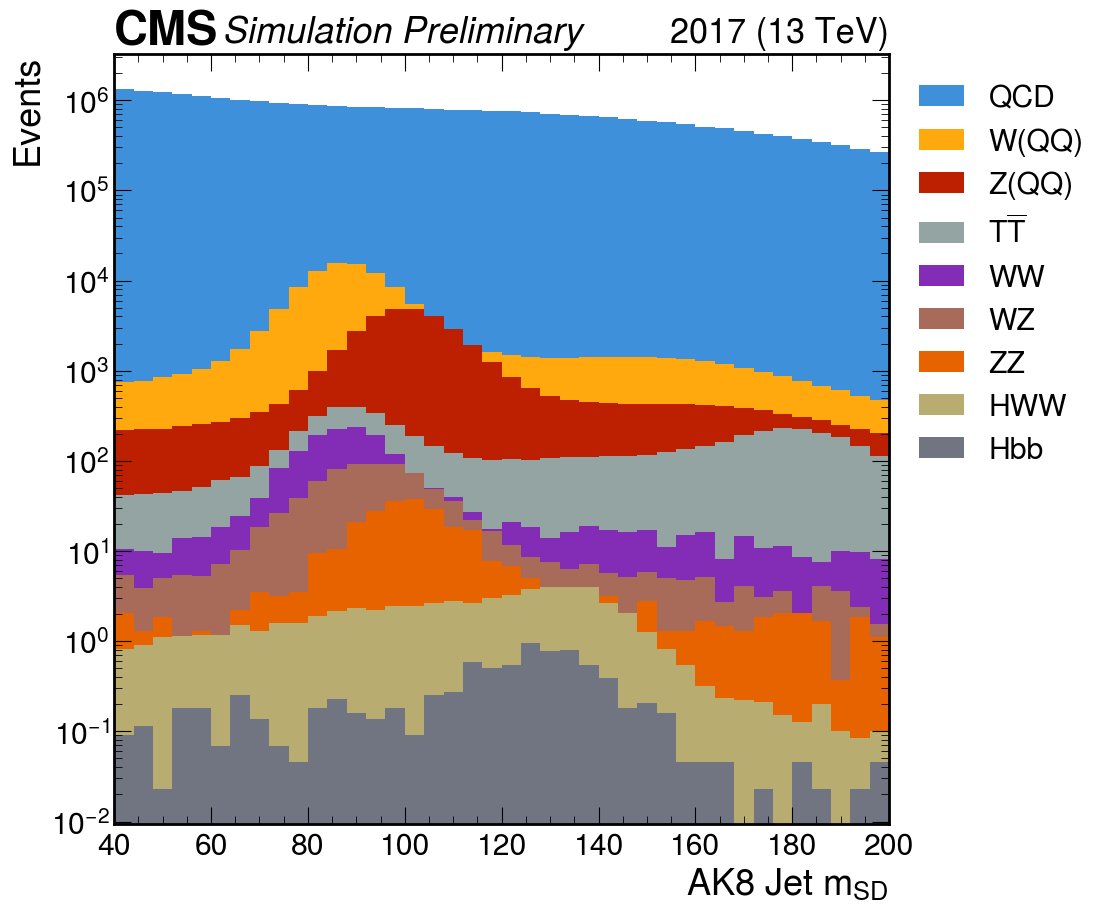

In [47]:
density=False
qcd.plot1d(label='QCD',stack=True, histtype='fill', density=density)
wqq.plot1d(label='W(QQ)',stack=True, histtype='fill', density=density)
zqq.plot1d(label='Z(QQ)',stack=True, histtype='fill', density=density)
ttboosted.plot1d(label=r'$T\overline{T}$',stack=True, histtype='fill', density=density)
hists['diboson_ww'].plot1d(label='WW',stack=True,histtype='fill', density=density)
hists['diboson_wz'].plot1d(label='WZ',stack=True,histtype='fill', density=density)
hists['diboson_zz'].plot1d(label='ZZ',stack=True,histtype='fill', density=density)
hists['hww'].plot1d(label='HWW',stack=True,histtype='fill', density=density)
hists['hbb'].plot1d(label='Hbb',stack=True,histtype='fill', density=density)
plt.legend(bbox_to_anchor=(1,1))
plt.xlim(40,200)
hep.cms.label('Preliminary', year=2017)
plt.xlabel(r'AK8 Jet $m_{SD}$')
# plt.ylabel(r'Events $\times 1e6$')
plt.ylabel(r'Events')
plt.yscale('log')
plt.gca().yaxis.get_offset_text().set_visible(False)
plt.show()